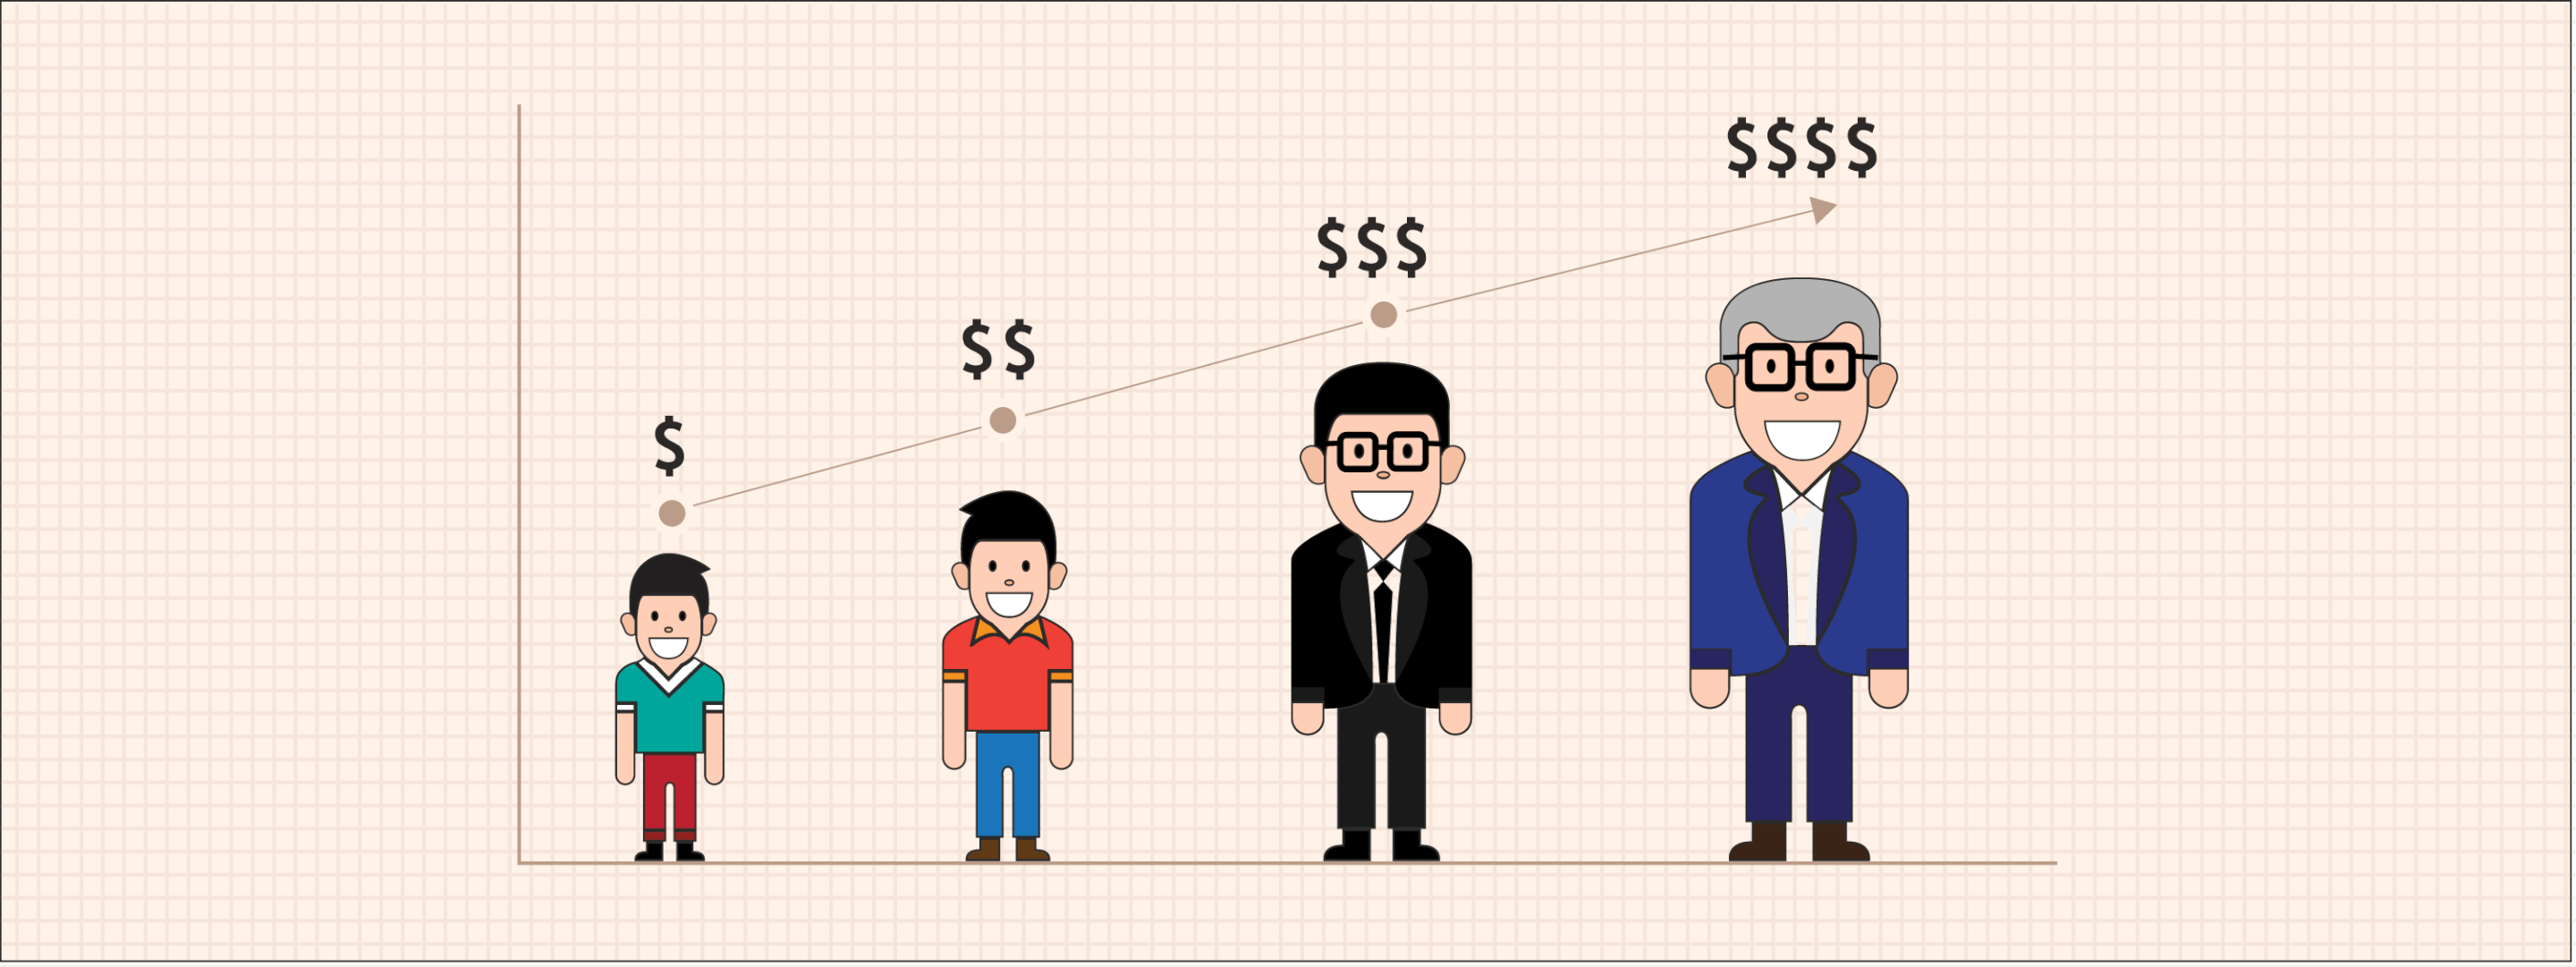

## Giriş

Bu çalışmada BG/NBD ve Gamma Gamma modeli ile CLTV değeri hesaplanmaya çalışılacaktır. Çalışmanın özeti şöyledir:
* 1-CLTV Nedir ve Nasıl Hesaplanır
* 2-Importing
* 3-Verinin Hazırlanması ve EDA
* 4-BG-NBD Modeli ile Expected Sales Forecasting
* 5-Gamma-Gamma Modeli ile Expected Average Profit
* 6-BG-NBD ve Gamma-Gamma Modeli ile CLTV'nin Hesaplanması
* 7-CLTV'ye Göre Segmentlerin Oluşturulması

## 1.1- CLTV Nedir?

CLTV ya da CLV kısa tanımıyla müşterinin yaşamı boyunca getireceği gelirlerin beklenen toplamıdır.Pazarlama dünyasında müşteriyi anlamak ve yönetmek için çok sık kullanılan
bir metriktir.

CLTV değerini doğru öngördüğünüz zaman müşterinin CLTV değerini arttırmak için aksiyon alabilirsiniz.

Mevcut müşteriyi elde tutmanın yeni müşteriler kazanmaktan daha kolay bir iş olduğu artık biliniyor.Bu durumda gelirlerimizi arttırmak için CLTV' yi arttırmak oldukça kullanılabilir bir yöntem.

## 1.2- CLTV Nasıl Hesaplanır ?

Yaşam boyu müşteri değeri hesaplamak için kullanılan pek çok farklı formül ve yaklaşım mevcut.Bu çalışmada BG/NBD ve Gamma Gamma yöntemi ile CLTV hesaplanacaktır.

* CLTV = (Customer Value / Churn Rate) * Profit Margin
* Customer Value = Average Order Value * Purchase Frequency
* Churn Rate = 1 — Repeat Rate
* CLTV = Expected Number of Transactions * Expected Average Profit
* CLTV = BG/NBD * Gamma Gamma Submodel



## 2 - Importing

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler


def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

## 3.1- Verinin Hazırlanması ve EDA

Değişkenler

* InvoiceNo: Fatura numarası. Her işleme yani faturaya ait eşsiz numara. C ile başlıyorsa iptal edilen işlem.
* StockCode: Ürün kodu. Her bir ürün için eşsiz numara.
* Description: Ürün ismi
* Quantity: Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.
* InvoiceDate: Fatura tarihi ve zamanı.
* UnitPrice: Ürün fiyatı (Sterlin cinsinden)
* CustomerID: Eşsiz müşteri numarası
* Country: Ülke ismi. Müşterinin yaşadığı ülke.

In [2]:
# Verinin okunması
df_=pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2010-2011" )
df=df_.copy()

In [3]:
# Ön İşleme Öncesi
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0000,9.5522,218.0810,-80995.0000,1.0000,3.0000,10.0000,80995.0000
Price,541910.0000,4.6111,96.7598,-11062.0600,1.2500,2.0800,4.1300,38970.0000
Customer ID,406830.0000,15287.6842,1713.6031,12346.0000,13953.0000,15152.0000,16791.0000,18287.0000


In [4]:
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]

replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

df["TotalPrice"] = df["Quantity"] * df["Price"]
today_date = dt.datetime(2011, 12, 11)

In [5]:
# Ön İşleme Sonrası
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,397925.0000,11.8337,25.5345,1.0000,2.0000,6.0000,12.0000,298.5000
Price,397925.0000,2.8932,3.2271,0.0000,1.2500,1.9500,3.7500,37.0600
Customer ID,397925.0000,15294.3086,1713.1727,12346.0000,13969.0000,15159.0000,16795.0000,18287.0000
TotalPrice,397925.0000,20.6277,51.8263,0.0000,4.6800,11.8000,19.8000,3268.5750


# 3.2-Lifetime Veri Yapısının Hazırlanması

* recency: Son satın alma üzerinden geçen zaman. Haftalık. (cltv_df'de analiz gününe göre, burada kullanıcı özelinde)
* T: Müşterinin yaşı. Haftalık. (analiz tarihinden ne kadar süre önce ilk satın alma yapılmış)
* frequency: tekrar eden toplam satın alma sayısı (frequency>1)
* monetary_value: satın alma başına ortalama kazanç

In [6]:
cltv_df = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                         lambda date: (today_date - date.min()).days],
                                         'Invoice': lambda num: num.nunique(),
                                         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

cltv_df.columns = cltv_df.columns.droplevel(0)
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

In [7]:
# monetary değerinin satın alma başına ortalama kazanç olarak ifade edilmesi
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

# monetary sıfırdan büyük olanların seçilmesi
cltv_df = cltv_df[cltv_df["monetary"] > 0]
cltv_df.head()

# BGNBD için recency ve T'nin haftalık cinsten ifade edilmesi
cltv_df["recency"] = cltv_df["recency"] / 7
cltv_df["T"] = cltv_df["T"] / 7

# frequency'nin 1'den büyük olması gerekmektedir.
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

## 4-BG-NBD Modeli ile Expected Sales Forecasting

In [8]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2845 subjects, a: 0.12, alpha: 11.40, b: 2.49, r: 2.18>

In [9]:
# 1 hafta içinde en çok satın alma beklediğimiz 10 müşteri kimdir?

bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

cltv_df.sort_values(by="expected_purc_1_week",ascending=False).head(10)

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12748.0000,53.1429,53.4286,210,154.1924,3.2652
14911.0000,53.1429,53.4286,201,691.7101,3.1266
17841.0000,53.0000,53.4286,124,330.1344,1.9403
13089.0000,52.2857,52.8571,97,606.3625,1.5375
14606.0000,53.1429,53.4286,93,130.1390,1.4640
15311.0000,53.2857,53.4286,91,667.7791,1.4337
12971.0000,52.5714,53.2857,86,127.4859,1.3570
14646.0000,50.4286,50.7143,74,3596.8044,1.2225
13408.0000,53.0000,53.4286,62,453.5006,0.9862


In [10]:
# 3 Ayda Tüm Şirketin Beklenen Satış Sayısı Nedir?
bgf.predict(4 * 3,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

5271.849715637094

## 5-Gamma-Gamma Modeli ile Expected Average Profit

In [11]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

cltv_df["expected_average_profit"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                             cltv_df['monetary'])

cltv_df.sort_values("expected_average_profit", ascending=False).head(20)

,recency,T,frequency,monetary,expected_purc_1_week,expected_average_profit
Customer ID,,,,,,
12415.0000,44.7143,48.2857,21,5724.3026,0.3796,5772.1772
12590.0000,0.0000,30.2857,2,4591.1725,0.0115,5029.4099
12435.0000,26.8571,38.2857,2,3914.9450,0.0763,4288.9357
12409.0000,14.7143,26.1429,3,3690.8900,0.1174,3918.8079
14088.0000,44.5714,46.1429,13,3864.5546,0.2603,3917.1286
18102.0000,52.2857,52.5714,60,3859.7391,0.9686,3870.9967
12753.0000,48.4286,51.8571,6,3571.5650,0.1261,3678.5761
14646.0000,50.4286,50.7143,74,3596.8044,1.2225,3605.3092
15749.0000,13.8571,47.5714,3,3028.7800,0.0280,3216.0483


## 6-BG-NBD ve Gamma-Gamma Modeli ile CLTV'nin Hesaplanması

In [12]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency'],
                                   cltv_df['T'],
                                   cltv_df['monetary'],
                                   time=3,  # 3 aylık
                                   freq="W",  # T'nin frekans bilgisi.
                                   discount_rate=0.01)

In [13]:
# CLV değeri en yüksek olan 10 müşterinin gösterimi
cltv = cltv.reset_index()
cltv.sort_values(by="clv", ascending=False)

cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_average_profit,clv
1122,14646.0000,50.4286,50.7143,74,3596.8044,1.2225,3605.3092,55722.4203
2761,18102.0000,52.2857,52.5714,60,3859.7391,0.9686,3870.9967,47415.6701
843,14096.0000,13.8571,14.5714,17,3163.5882,0.7288,3196.4354,29066.0386
36,12415.0000,44.7143,48.2857,21,5724.3026,0.3796,5772.1772,27686.5223
1257,14911.0000,53.1429,53.4286,201,691.7101,3.1266,692.3264,27379.3414
2458,17450.0000,51.2857,52.5714,46,2863.2749,0.7475,2874.1985,27167.7406
874,14156.0000,51.5714,53.1429,55,2104.0267,0.8776,2110.7541,23425.8613
2487,17511.0000,52.8571,53.4286,31,2933.9431,0.5089,2950.5798,18987.6767
2075,16684.0000,50.4286,51.2857,28,2209.9691,0.4781,2223.8847,13441.1749
650,13694.0000,52.7143,53.4286,50,1275.7005,0.8009,1280.2182,12966.9410


In [14]:
# CLTV'nin Standartlaştırılması
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(cltv_final[["clv"]])
cltv_final["scaled_clv"] = scaler.transform(cltv_final[["clv"]])

## 7-CLTV'ye Göre Segmentlerin Oluşturulması

In [15]:
# Müşterileri 4 gruba ayıralım:
cltv_final["segment"] = pd.qcut(cltv_final["scaled_clv"], 4, labels=["D", "C", "B", "A"])
cltv_final.head(10)


,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_average_profit,clv,scaled_clv,segment
0,12347.0000,52.1429,52.5714,7,615.7143,0.1413,631.9120,1128.4614,0.0203,A
1,12348.0000,40.2857,51.2857,4,442.6950,0.0920,463.7455,538.7980,0.0097,B
2,12352.0000,37.1429,42.4286,8,219.5425,0.1824,224.8867,517.5148,0.0093,B
3,12356.0000,43.1429,46.5714,3,937.1433,0.0862,995.9977,1083.0593,0.0194,A
4,12358.0000,21.2857,21.5714,2,575.2100,0.1223,631.9010,966.6801,0.0173,A
5,12359.0000,39.1429,47.4286,4,1371.8500,0.0995,1435.0372,1802.1464,0.0323,A
6,12360.0000,21.1429,28.7143,3,878.5333,0.1196,933.7894,1402.8144,0.0252,A
7,12362.0000,41.7143,42.2857,10,522.6230,0.2240,532.2316,1504.2750,0.0270,A
8,12363.0000,18.8571,34.7143,2,276.0000,0.0756,304.2638,289.3549,0.0052,C
9,12364.0000,14.8571,16.1429,4,328.2750,0.2176,344.1367,934.3295,0.0168,A


In [16]:
# Segmentleri betimleyelim:
cltv_final.groupby("segment").agg({"count", "mean", "sum"})

Customer ID                     recency                        T                  frequency             monetary                   expected_purc_1_week                expected_average_profit                         clv                    scaled_clv              
               mean count           sum    mean count        sum    mean count        sum      mean count   sum     mean count         sum                 mean count      sum                    mean count         sum      mean count          sum       mean count     sum
segment                                                                                                                                                                                                                                                                       
D        15557.6489   712 11077046.0000 22.0724   712 15715.5714 40.4723   712 28816.2857    3.0674   712  2184 183.9167   712 130948.6756               0.0711   712  50.6043                199.3813   712 141959.4892  143.2716   712  102009.4096     0.0026   712  1.8307
C        15310.4627   711 10885739.0000 30.6711   711 21807.1429 38.1037   711 27091.7143    4.0942   711  2911 271.6811   711 193165.2739               0.1206   711  85.7300                289.9760   711 206172.9514  380.7692   711  270726.9237     0.0068   711  4.8585
B        15352.8186   711 10915854.0000 29.5148   711 20985.0000 34.8117   711 24751.1429    5.4416   711  3869 373.4425   711 265517.6312               0.1625   711 115.5115                393.8940   711 280058.6456  688.2805   711  489367.4307     0.0124   711  8.7822
A        14947.3586   711 10627572.0000 31.4109   711 22333.1429 34.4840   711 24518.1429   11.3615   711  8078 659.7883   711 469109.4490               0.2736   711 194.5443                685.8285   711 487624.0925 2222.4586   711 1580168.0736     0.0399   711 28.3579